In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Total images: 5758
Image shape: (224, 224, 3)
Max pixel value after normalization: 1.0
Min pixel value after normalization: 0.0


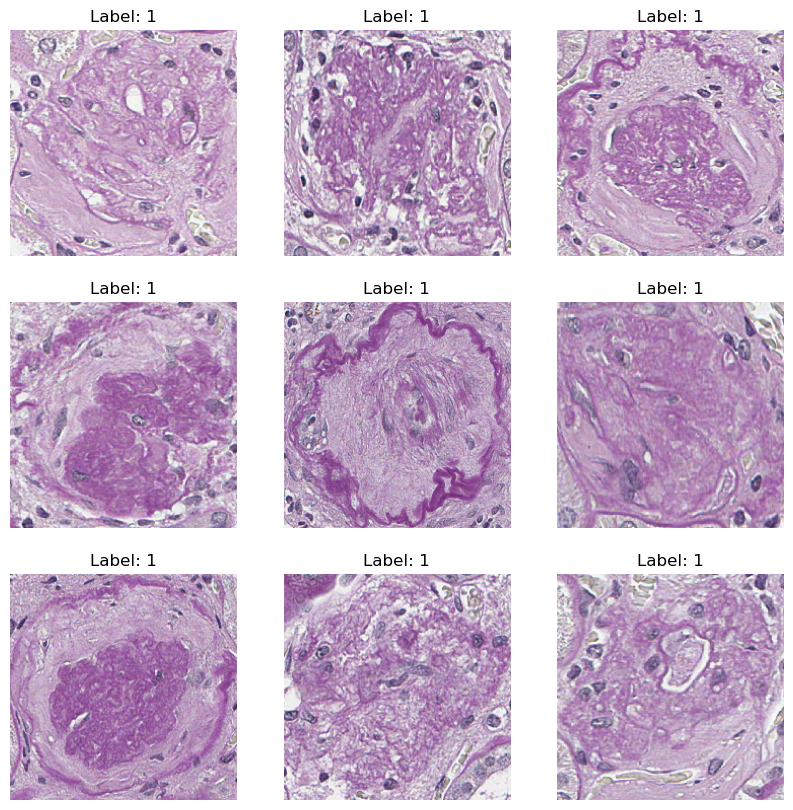

Training data shape: (4606, 224, 224, 3)
Total non-sclerotic images: 3778
Total sclerotic images: 828
Test data shape: (1152, 224, 224, 3)
Total non-sclerotic images: 926
Training labels shape: (4606,)
Test labels shape: (1152,)


In [4]:
# Define paths 
globally_sclerotic_path = 'public/globally_sclerotic_glomeruli'
non_globally_sclerotic_path = 'public/non_globally_sclerotic_glomeruli'
csv_file_path = 'public/public.csv'

# Image target size (e.g., 224x224)
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Function to load images from a directory, resize, and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Load and resize image
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load images
globally_sclerotic_images, globally_sclerotic_labels = load_images_from_directory(globally_sclerotic_path, 1)
non_globally_sclerotic_images, non_globally_sclerotic_labels = load_images_from_directory(non_globally_sclerotic_path, 0)

# Combine datasets
X = np.concatenate([globally_sclerotic_images, non_globally_sclerotic_images], axis=0)
y = np.concatenate([globally_sclerotic_labels, non_globally_sclerotic_labels], axis=0)

# Normalize images
X = X / 255.0

# Verify normalization
print(f'Total images: {len(X)}')

print(f'Image shape: {X[0].shape}')
print(f'Max pixel value after normalization: {X.max()}')
print(f'Min pixel value after normalization: {X.min()}')

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i])
    plt.title(f'Label: {y[i]}')
    plt.axis('off')
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print(f'Training data shape: {X_train.shape}')
print(f'Total non-sclerotic images: {len(X_train[y_train == 0])}')
print(f'Total sclerotic images: {len(X_train[y_train == 1])}')
print(f'Test data shape: {X_test.shape}')
print(f'Total non-sclerotic images: {len(X_test[y_test == 0])}')
print(f'Training labels shape: {y_train.shape}')
print(f'Test labels shape: {y_test.shape}')

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',classes =  np.unique(y_train), y = y_train)

print(class_weights)
class_weights = {0: class_weights[0], 1: class_weights[1]}

[0.60958179 2.78140097]


In [13]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, class_weight = class_weights , epochs=30, batch_size=32, validation_split=0.2, shuffle=True)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Make a csv file with the image name and the prediction
predictions = model.predict(X_test)
predictions = predictions.flatten()


Epoch 1/30
116/116 [==============================] - 98s 832ms/step - loss: 0.5265 - accuracy: 0.7625 - val_loss: 0.2589 - val_accuracy: 0.9013
Epoch 2/30
116/116 [==============================] - 96s 830ms/step - loss: 0.3514 - accuracy: 0.8787 - val_loss: 0.3418 - val_accuracy: 0.8774
Epoch 3/30
116/116 [==============================] - 91s 781ms/step - loss: 0.3096 - accuracy: 0.8906 - val_loss: 0.2667 - val_accuracy: 0.9132
Epoch 4/30
116/116 [==============================] - 90s 779ms/step - loss: 0.2395 - accuracy: 0.9210 - val_loss: 0.5722 - val_accuracy: 0.7505
Epoch 5/30
116/116 [==============================] - 92s 792ms/step - loss: 0.2050 - accuracy: 0.9270 - val_loss: 0.3727 - val_accuracy: 0.8547
Epoch 6/30
116/116 [==============================] - 89s 771ms/step - loss: 0.1622 - accuracy: 0.9406 - val_loss: 0.1467 - val_accuracy: 0.9458
Epoch 7/30
116/116 [==============================] - 90s 777ms/step - loss: 0.1278 - accuracy: 0.9568 - val_loss: 0.1631 - val_ac

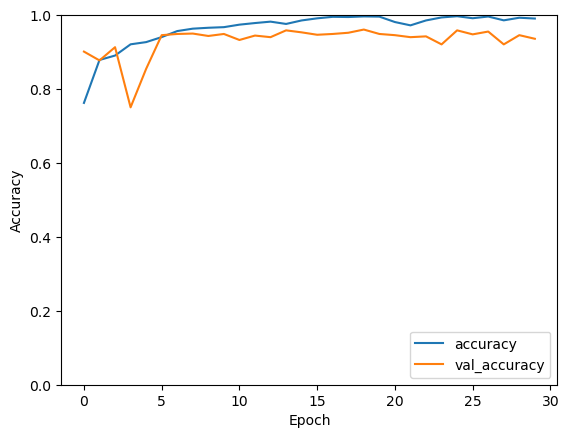

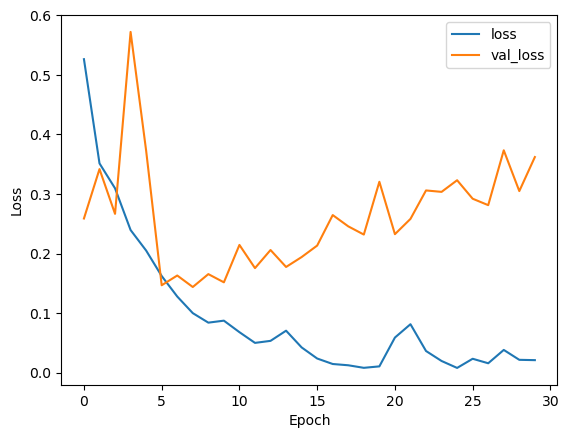

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 6s 161ms/step
[[902  24]
 [ 80 146]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       926
           1       0.86      0.65      0.74       226

    accuracy                           0.91      1152
   macro avg       0.89      0.81      0.84      1152
weighted avg       0.91      0.91      0.90      1152



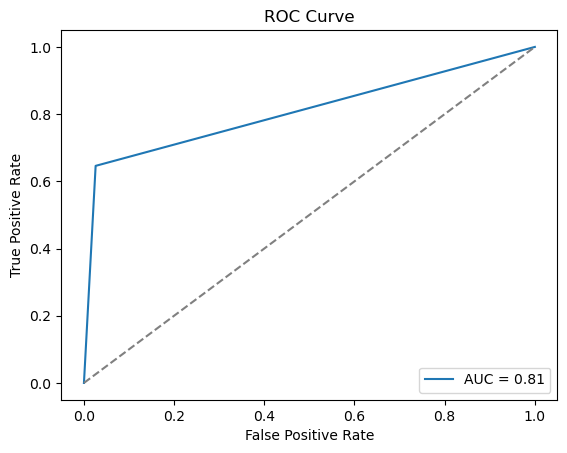

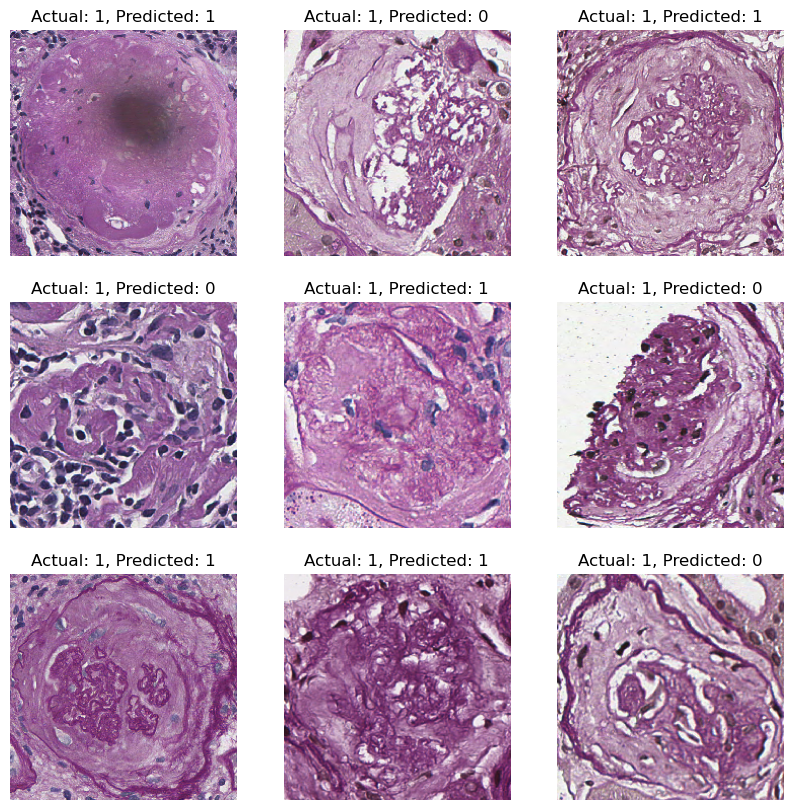

In [14]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Save the model
model.save('glomeruli_model.h5')

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)



#Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Show some predictions that were incorrect
incorrect_indices = np.where(y_pred != y_test)[1]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    plt.title(f'Actual: {y_test[idx]}, Predicted: {y_pred[idx][0]}')
    plt.axis('off')
plt.show()